In [1]:
import jax
import numpy as onp
import jax.numpy as jnp
from jax import grad, jacfwd
import mesh_processing as mp
import pmm

try:
    import meshplot as mplot
    meshplot_available = True
except ImportError as e:
    meshplot_available = False

import matplotlib.pyplot as plt

In [2]:
V_pc,F_pc = mp.objloader('project2/meshes/Spheroids/','partial_cubified.obj')
V_s,F_s = mp.objloader('project2/meshes/Spheroids/','Sphere.obj')
V_c,F_c = mp.objloader('project2/meshes/Spheroids/','cubified.obj')
V_t,F_t = mp.objloader('project2/meshes/Torus_remesh/','Torus.obj')
V_t1,F_t1 = mp.objloader('project2/meshes/Torus_remesh/','Torus_sub1.obj')
V_t2,F_t2 = mp.objloader('project2/meshes/Torus_remesh/','Torus_sub2.obj')

/home/dith/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
def to_numpy_array(X):
    Np_array = onp.zeros(X.shape)
    for n in range(X.shape[0]):
        Np_array[n] = X[n]
    return Np_array

def plot_mesh(V,F):
    if meshplot_available:
        V_plot = to_numpy_array(V)
        F_plot = to_numpy_array(F)
        mplot.plot(V_plot,F_plot)
    else:
        print('Did not plot - meshplot not available')

plot_mesh(V_t,F_t)
#plot_mesh(V_c,F_c)
#plot_mesh(V_s,F_s)

Did not plot - meshplot not available


In [4]:
N_pc,A_pc = mp.compute_normals_and_areas(V_pc,F_pc)
N_s,A_s = mp.compute_normals_and_areas(V_s,F_s)
N_c,A_c = mp.compute_normals_and_areas(V_c,F_c)

In [5]:
def center_of_mass(V,F):
    return (V[F[:,0]]+V[F[:,1]]+V[F[:,2]])/3

In [6]:
def Gaussian_Kernel(sigma):
    def f(x,y):
        return jnp.exp(-jnp.linalg.norm(x-y)**2/(2*sigma**2))
    return f

def Gaussian_Kernel_Norm(sigma):
    def f(norm):
        return jnp.exp(-norm**2/(2*sigma**2))
    return f
    

#Set Kernel

def distCurves(V1,F1,V2,F2,sigma):
    N_1,A1 = mp.compute_normals_and_areas(V1,F1)
    N_2,A2 = mp.compute_normals_and_areas(V2,F2)
    N1 = N_1*A1.reshape(-1,1)
    N2 = N_2*A2.reshape(-1,1)
    M1 = center_of_mass(V1,F1)
    M2 = center_of_mass(V2,F2)
    #print(jnp.shape(N1))
    D = jnp.vectorize(lambda x,y: x-y)
    def term(m1,m2,n1,n2):
        Km = jnp.exp(-(D(m1[:,0].reshape(-1,1),m2[:,0].reshape(1,-1))**2+D(m1[:,1].reshape(-1,1),m2[:,1].reshape(1,-1))**2+D(m1[:,2].reshape(-1,1),m2[:,2].reshape(1,-1))**2)*1/(2*sigma**2))
        #print(jnp.shape(jnp.dot(n1, n2.T)*Km))
        return jnp.sum(jnp.dot(n1, n2.T)*Km)
    term1 = term(M1,M1,N1,N1)
    term2 = term(M2,M2,N2,N2)
    term3 = -2*term(M1,M2,N1,N2)
    res = term1 + term2 + term3
    return jnp.sqrt(jnp.clip(res, 0, None))

def final_distCurves(V1,F1,V2,F2,sigma):
    return distCurves(V1,F1,V2,F2,sigma)
    #return min(distCurves(V1,F1,V2,F2,sigma), distCurves(V1,F1,-V2,F2,sigma))

In [7]:
def scalar_dist(c,V,F):
    return final_distCurves(V,F,V+c,F,2)

print(scalar_dist(jnp.float32(1),V_s,F_s))

5.7936683


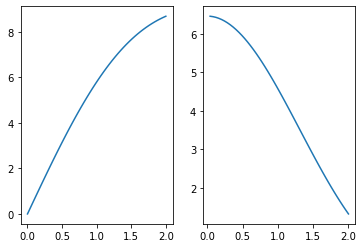

In [8]:
grad(scalar_dist)(jnp.float32(1.01),V_s,F_s)
x = onp.linspace(0, 2, 50)
y = [grad(scalar_dist)(jnp.float32(n),V_s,F_s) for n in x]
z = [scalar_dist(jnp.float32(n),V_s,F_s) for n in x]
plt.figure()
plt.subplot(1,2,1)
plt.plot(x,z)
plt.subplot(1,2,2)
plt.plot(x,y)
plt.show()

In [9]:
plot_mesh((-1)*V_s,F_s)

Did not plot - meshplot not available


In [10]:
print(scalar_dist(jnp.float32(1),V_s,F_s),scalar_dist(jnp.float32(-1),V_s,F_s))

5.7936683 5.7936683


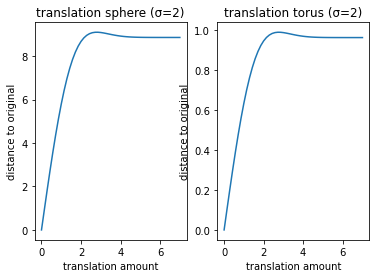

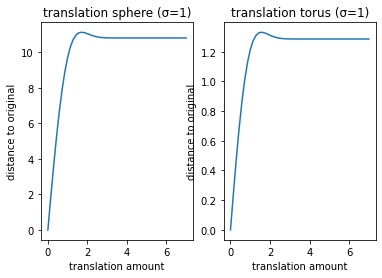

In [28]:
x = jnp.linspace(0, 7, 50)
y = pmm.translate_x(distCurves, V_s, F_s, x)
z = pmm.translate_x(distCurves, V_t, F_t, x)

plt.subplot(1,2,1)
plt.title('translation sphere (σ=2)')
plt.plot(x, y)
plt.xlabel('translation amount')
plt.ylabel('distance to original')

plt.subplot(1,2,2)
plt.title('translation torus (σ=2)')
plt.plot(x, z)
plt.xlabel('translation amount')
plt.ylabel('distance to original')

plt.show()

x = jnp.linspace(0, 7, 50)
y = pmm.translate_x(distCurves, V_s, F_s, x, 1)
z = pmm.translate_x(distCurves, V_t, F_t, x, 1)

plt.subplot(1,2,1)
plt.title('translation sphere (σ=1)')
plt.plot(x, y)
plt.xlabel('translation amount')
plt.ylabel('distance to original')

plt.subplot(1,2,2)
plt.title('translation torus (σ=1)')
plt.plot(x, z)
plt.xlabel('translation amount')
plt.ylabel('distance to original')

plt.show()

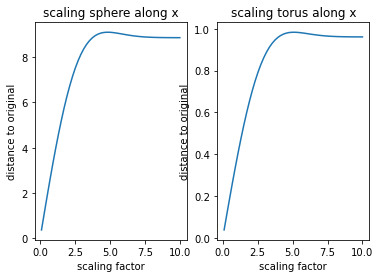

In [12]:
x = jnp.linspace(0.1, 10, 50)
y = pmm.scale_x(distCurves, V_s, F_s, x)
z = pmm.scale_x(distCurves, V_t, F_t, x)

plt.subplot(1,2,1)
plt.title('scaling sphere along x')
plt.plot(x, y)
plt.xlabel('scaling factor')
plt.ylabel('distance to original')

plt.subplot(1,2,2)
plt.title('scaling torus along x')
plt.plot(x, z)
plt.xlabel('scaling factor')
plt.ylabel('distance to original')

plt.show()

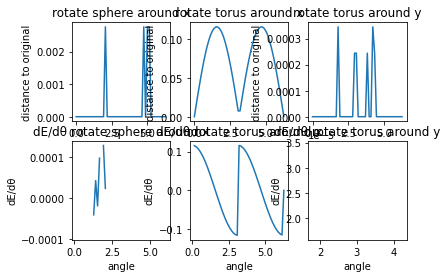

In [13]:
x = jnp.linspace(0, 2*jnp.pi, 50)
y = pmm.rotate_x(distCurves, V_s, F_s, x)
z1 = pmm.rotate_x(distCurves, V_t, F_t, x)
z2 = pmm.rotate_y(distCurves, V_t, F_t, x)
#print(x[4],jnp.where(jnp.isnan(z2)))

ddy  = [grad(lambda v: pmm.rotate_x(distCurves, V_s, F_s, jnp.array(v)))(v_) for v_ in x]
ddz1 = [grad(lambda v: pmm.rotate_x(distCurves, V_t, F_t, jnp.array(v)))(v_) for v_ in x]
ddz2 = [grad(lambda v: pmm.rotate_y(distCurves, V_t, F_t, jnp.array(v)))(v_) for v_ in x]

plt.subplot(2,3,1)
plt.title('rotate sphere around x')
plt.plot(x, y)
plt.xlabel('angle')
plt.ylabel('distance to original')

plt.subplot(2,3,2)
plt.title('rotate torus around x')
plt.plot(x, z1)
plt.xlabel('angle')
plt.ylabel('distance to original')

plt.subplot(2,3,3)
plt.title('rotate torus around y')
plt.plot(x, z2)
plt.xlabel('angle')
plt.ylabel('distance to original')
            
plt.subplot(2,3,4)
plt.title('dE/dθ rotate sphere around x')
plt.plot(x, ddy)
plt.xlabel('angle')
plt.ylabel('dE/dθ')

plt.subplot(2,3,5)
plt.title('dE/dθ rotate torus around x')
plt.plot(x, ddz1)
plt.xlabel('angle')
plt.ylabel('dE/dθ')

plt.subplot(2,3,6)
plt.title('dE/dθ rotate torus around y')
plt.plot(x, ddz2)
plt.xlabel('angle')
plt.ylabel('dE/dθ')
plt.show()

In [14]:
D = jnp.vectorize(lambda x,y: x - y)
print(V_s.shape)

dists = D(V_s[:,0].reshape(-1,1), V_s[:,0].reshape(1,-1))**2 + \
        D(V_s[:,1].reshape(-1,1), V_s[:,1].reshape(1,-1))**2 + \
        D(V_s[:,2].reshape(-1,1), V_s[:,2].reshape(1,-1))**2

min_dist = jnp.sqrt(jnp.min(dists[jnp.triu(dists, 1)>0]))

print(min_dist.shape)
print('min dist:', min_dist)

(1538, 3)
()
min dist: 0.07878168


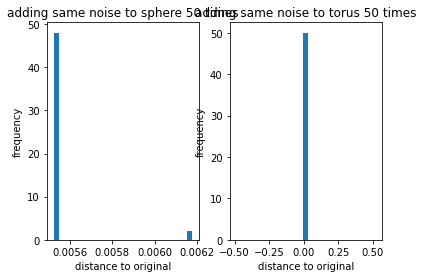

In [15]:
x = jnp.ones(50)*min_dist/2
y = pmm.add_noise(distCurves, V_s, F_s, x)
z = pmm.add_noise(distCurves, V_t, F_t, x)

plt.subplot(1,2,1)
plt.title('adding same noise to sphere 50 times')
plt.hist(y,bins=25)
plt.xlabel('distance to original')
plt.ylabel('frequency')

plt.subplot(1,2,2)
plt.title('adding same noise to torus 50 times')
plt.hist(z,bins=25)
plt.xlabel('distance to original')
plt.ylabel('frequency')

plt.show()

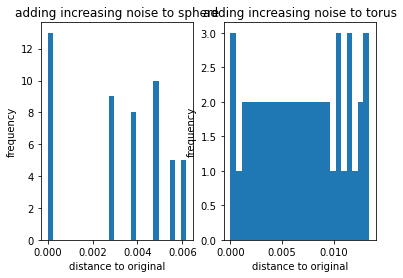

In [16]:
x = jnp.linspace(0,min_dist/2,50)
y = pmm.add_noise(distCurves, V_s, F_s, x)
z = pmm.add_noise(distCurves, V_t, F_t, x)

plt.subplot(1,2,1)
plt.title('adding increasing noise to sphere')
plt.hist(y,bins=25)
plt.xlabel('distance to original')
plt.ylabel('frequency')

plt.subplot(1,2,2)
plt.title('adding increasing noise to torus')
plt.hist(z,bins=25)
plt.xlabel('distance to original')
plt.ylabel('frequency')

plt.show()

In [23]:
x0 = jnp.linspace(0.0, 2*jnp.pi, 25)
y0 = pmm.rotate_x(distCurves, V_t, F_t, x0)

In [24]:
x1 = jnp.linspace(0.0, 2*jnp.pi, 25)
y1 = pmm.rotate_x(distCurves, V_t1, F_t1, x1)

In [19]:
x2 = jnp.linspace(0.0, 2*jnp.pi, 9)
y21 = pmm.rotate_x(distCurves, V_t2, F_t2, x2[:3])

In [20]:
y22 = pmm.rotate_x(distCurves, V_t2, F_t2, x2[3:6])

In [21]:
y23 = pmm.rotate_x(distCurves, V_t2, F_t2, x2[6:])

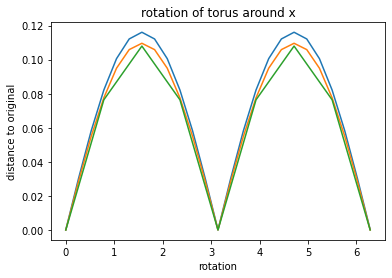

In [25]:
plt.plot(x0, y0, label=f'mesh faces: {len(F_t)}')
plt.plot(x1, y1, label=f'mesh faces: {len(F_t1)}')
plt.plot(x2, jnp.concatenate([y21, y22, y23]), label=f'mesh faces: {len(F_t2)}')

plt.title('rotation of torus around x')
plt.xlabel('rotation')
plt.ylabel('distance to original')

plt.show()

In [27]:
print(distCurves(V_t, F_t, V_t2, F_t2, 2))
print(distCurves(V_t, F_t, V_t1, F_t1, 2))
print(distCurves(V_t1, F_t1, V_t2, F_t2, 2))

0.043382216
0.034851447
0.0085309595
